## Predict Ethereum price using Recurrent Neural Networks (LSTM)

In [1]:
# Import neccessary packages
import numpy as np 
import pandas as pd 
import math
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping 
from keras.models import load_model

from keras.backend import clear_session

import warnings
warnings.filterwarnings("ignore")

##### First of all, I define some functions we are going to use.

In [2]:
def partition_dataset(window_length, data, index_target):
    """
    The LSTM needs data with the format of [samples, time steps, features], 
    so we create N samples, window_length time steps per sample, and number of features
    """
    x, y = [], []
    data_len = data.shape[0]
    for i in range(window_length, data_len):
        x.append(data[i-window_length:i,:])
        y.append(data[i, index_target])
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [3]:
def regression_metrics(y_test, y_pred):
    
    """
    Define evaluation metrics for regression problem
    Parameters: y_test: true values
                y_pred: predicted values
    """
    
    print('R2 Score: ', r2_score(y_test, y_pred))
    print('Mean Absolute Error: ', mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error: ', mean_squared_error(y_test, y_pred))
    MDAPE = np.mean((np.abs(np.subtract(y_test, y_pred)/ y_test)) ) * 100
    print(f'Mean Absolute Percentage Error: {np.round(MDAPE, 2)} %')

In [4]:
def history_accuracy_loss(history):

    """ Plot training & testing loss values """
    
    fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
    plt.plot(history.history["loss"])
    plt.plot(history.history['val_loss'])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
    plt.legend(["Training", "Testing"], loc="upper left")
    plt.grid()
    plt.show()

In [5]:
def plot_actual_predicted(original, predictions, title):
     
    """ Visualize actual and predicted price """
    
    ax = sns.lineplot(x=original.index, y=original[0], label="Real Price", color='royalblue',linewidth=2)
    ax = sns.lineplot(x=predictions.index, y=predictions[0], label="Predicted Price", color='tomato',linewidth=2)
    ax.set_title(title, size = 20)
    ax.set_xlabel("Date", size = 16)
    ax.set_ylabel("Price (USD)", size = 16)
    ax.set_xticklabels('', size=16);
    plt.grid()
    set_size(10,5)

In [6]:
def set_size(w, h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

### 1. Data loading

In [7]:
df = pd.read_csv('data/eth_clean.csv')
df.drop(columns='Unnamed: 0', inplace = True)
df

,date,PriceUSD,AdrActCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1MCnt,CapMrktCurUSD,DiffLast,...,FlowInExUSD,FlowOutExUSD,GasUsedTx,GasUsedTxMean,HashRate,RevHashNtv,RevHashRateUSD,SplyAdrBalUSD1M,TxCnt,TxTfrValMedUSD
0,2015-08-08,1.199990,1208,9958,10267,9550,10115,8111,8.676871e+07,1606016380751,...,1.033888e+06,1.698517e+04,376006093,130512.354391,0.096483,3.360253,348388.084065,1.661840e+07,2881,1.199990
1,2015-08-09,1.199990,1113,10043,10411,9573,10222,8091,8.680133e+07,1741399466631,...,6.414313e+05,1.127113e+05,38863003,29242.289691,0.101360,3.105048,321928.661618,1.682678e+07,1329,15.599147
2,2015-08-10,1.199990,1430,10145,10572,9611,10348,8101,8.683471e+07,1948102094734,...,1.055335e+06,2.135630e+05,74070061,36362.327442,0.111855,2.881582,298759.890307,1.720648e+07,2037,0.718002
3,2015-08-11,0.990000,2697,10188,10706,9614,10429,8081,7.166698e+07,2171897473895,...,4.513437e+05,1.752126e+05,163481740,32940.104775,0.124450,2.607691,223051.462249,1.551874e+07,4963,0.053993
4,2015-08-12,1.288000,1219,10296,10893,9654,10574,8105,9.327472e+07,2248237602936,...,4.743256e+05,1.891297e+05,70102332,34431.400786,0.130915,2.422720,269607.996077,1.851254e+07,2036,12.880000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,2021-11-15,4569.407770,606036,1166692,18202185,241239,5573039,36595,5.367033e+11,11263394429417836,...,8.676790e+08,1.029855e+10,97422476367,75542.615410,817.739849,0.000213,84078.925802,1.025092e+08,1289636,456.940777
2292,2021-11-16,4234.131465,609879,1165639,18237665,240967,5580973,36564,4.973249e+11,10918227329653401,...,1.755198e+09,1.678261e+09,96356492010,73545.984332,793.794054,0.000219,80290.211052,1.022489e+08,1310153,423.413146
2293,2021-11-17,4265.599006,695412,1167736,18217312,241192,5589438,36563,5.010266e+11,11549986846583558,...,1.167281e+09,1.282525e+09,98477697827,72772.919850,830.259240,0.000207,76139.406528,1.022624e+08,1353219,319.823949
2294,2021-11-18,3985.674373,591159,1170963,18239379,241438,5599347,36605,4.681491e+11,11579207148357743,...,1.555602e+09,1.424465e+09,98258045079,76510.060408,851.155962,0.000203,69860.008277,1.019504e+08,1284250,398.991334


### 2. Data Processing

In [8]:
def data_processing(df):
    # copy from raw data
    data = df.copy()

    # drop the timestamp columns as it is not used as a predictor
    data.drop(columns='date', inplace=True)

    # ensure all data is float
    data = data.astype(float)

    # normalize the dataset
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(data.values)

    # scale one feature for reversion purpose later
    scaler_pred = MinMaxScaler()
    df_PriceUSD = pd.DataFrame(data['PriceUSD'])
    np_PriceUSD_scaled = scaler_pred.fit_transform(df_PriceUSD)
    
    return data, scaler, scaler_pred, np_data_scaled

In [9]:
data, scaler, scaler_pred, np_data_scaled = data_processing(df)

### 3. Data Transformation

- The first 90% of the data is used in training the model, and the last 10% will be used to test the model.
- The RNN-LSTM needs data with the format of [samples, time steps, features], so let's transform data from [num rows x num features] to N samples, sequence_length time steps per sample, and number of features

In [10]:
def data_transformation(data, sequence_length, np_data_scaled, index_target):
    
    # Split the training data into train and train data sets
    train_data_len = math.ceil(np_data_scaled.shape[0] * 0.9)

    # Create the training and test data
    train_data = np_data_scaled[0:train_data_len, :]
    test_data = np_data_scaled[train_data_len - sequence_length:, :]

    # Generate training data and test data
    x_train, y_train = partition_dataset(sequence_length, train_data, index_target)
    x_test, y_test = partition_dataset(sequence_length, test_data, index_target)

    # Print the shapes:
    print('X_train shape: ', x_train.shape)
    print('y_train shape: ', y_train.shape)
    print('X_test shape: ', x_test.shape)
    print('y_test shape: ', y_test.shape)
    
    return x_train, y_train, x_test, y_test

In [11]:
# Data transformation
sequence_length = 7
x_train, y_train, x_test, y_test = data_transformation(data, sequence_length, np_data_scaled, data.columns.get_loc("PriceUSD"))

X_train shape:  (2060, 7, 22)
y_train shape:  (2060,)
X_test shape:  (229, 7, 22)
y_test shape:  (229,)


### 4. Creating the LSTM Model

In the project, I developed two multivariate recurrent neural networks for time series prediction using Long Short-Term Memory (LSTM). The first model has two LSTM layers, which take our mini-batches as input and return 168 values. Next is a dense layer with 50 neurons and the final dense layer that outputs the predicted value. Model 2 is like Model 1 but includes three LSTM layers, followed by the Dropout function after each LSTM layer to reduce overfitting.

In [12]:
def model_1(x_train):
    
    """
    Model 1:
    - Two LSTM layers with number of neurons is window length * number of features, the input shape is (x_train.shape[1], x_train.shape[2])
    - One fully connect layer with 50 neurons
    - The final dense layer that outputs the predicted value
    - Adam Optimizer
    - Set the loss as the mean_squarred_error
    
    """
    # initial the model
    model = Sequential()

    # Model with n_neurons = window length * number of features
    n_neurons = x_train.shape[1] * x_train.shape[2]

    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dense(50))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    model.summary()
    
    return model

In [13]:
def model_2(x_train, dropout):
    
    """
    Model 2 includes:
    - three LSTM layers, with number of neurons is window length * number of features, the input shape is (x_train.shape[1], x_train.shape[2])
    - Three dropout layers defining after each LSTM layer
    - One fully connect layer with 50 neurons 
    - The final dense layer that outputs the predicted value
    - Adam Optimizer
    - Set the loss as the mean_squarred_error
    
    """
    
    # Configure the neural network model
    model = Sequential()

    # Model with n_neurons = window length * number of features
    n_neurons = x_train.shape[1] * x_train.shape[2]

    model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
    model.add(Dropout(dropout))
    
    model.add(LSTM(n_neurons, return_sequences=True))
    model.add(Dropout(dropout))
    
    model.add(LSTM(n_neurons, return_sequences=False))
    model.add(Dropout(dropout))
    
    model.add(Dense(50))
    
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mse')
    
    model.summary()
    
    return model

### 5. Training the model

In [14]:
epochs = 50
batch_size = 32

##### Model 1 Training

In [15]:
model_1 = model_1(x_train)
history_1 = model_1.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test))

2021-11-27 17:20:59.536999: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 154)            109032    
_________________________________________________________________
lstm_1 (LSTM)                (None, 154)               190344    
_________________________________________________________________
dense (Dense)                (None, 50)                7750      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 307,177
Trainable params: 307,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2021-11-27 17:21:00.014840: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


65/65 [==============================] - 5s 38ms/step - loss: 0.0027 - val_loss: 0.0164
Epoch 2/50
65/65 [==============================] - 2s 28ms/step - loss: 2.1372e-04 - val_loss: 0.0134
Epoch 3/50
65/65 [==============================] - 2s 28ms/step - loss: 1.9477e-04 - val_loss: 0.0155
Epoch 4/50
65/65 [==============================] - 2s 26ms/step - loss: 1.9105e-04 - val_loss: 0.0053
Epoch 5/50
65/65 [==============================] - 2s 25ms/step - loss: 1.4659e-04 - val_loss: 0.0045
Epoch 6/50
65/65 [==============================] - 2s 25ms/step - loss: 1.1940e-04 - val_loss: 0.0035
Epoch 7/50
65/65 [==============================] - 2s 25ms/step - loss: 1.2777e-04 - val_loss: 0.0042
Epoch 8/50
65/65 [==============================] - 2s 25ms/step - loss: 1.0384e-04 - val_loss: 0.0034
Epoch 9/50
65/65 [==============================] - 2s 25ms/step - loss: 1.0437e-04 - val_loss: 0.0038
Epoch 10/50
65/65 [==============================] - 2s 25ms/step - loss: 1.5218e-04 - v

##### Model 2 Training

In [16]:
# Clear session before training model 2 
clear_session()

model_2 = model_2(x_train, 0.1)
history_2 = model_2.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 154)            109032    
_________________________________________________________________
dropout (Dropout)            (None, 7, 154)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 154)            190344    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 154)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 154)               190344    
_________________________________________________________________
dropout_2 (Dropout)          (None, 154)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                7

### 6. Evaluate Model Performance

In [17]:
def evaluate_model(model, x_test, y_test, scaler_pred):

    # Predict the Ether price
    y_pred_scaled = model.predict(x_test)

    # Unscale the predicted values
    y_pred = scaler_pred.inverse_transform(y_pred_scaled)
    y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

    # Evaluate the model
    regression_metrics(y_test_unscaled, y_pred)
    
    return y_test_unscaled, y_pred

##### Model 1 Evaluation

R2 Score:  0.9529394421545745
Mean Absolute Error:  121.93164002285002
Mean Squared Error:  29300.94213991256
Mean Absolute Percentage Error: 4.19 %


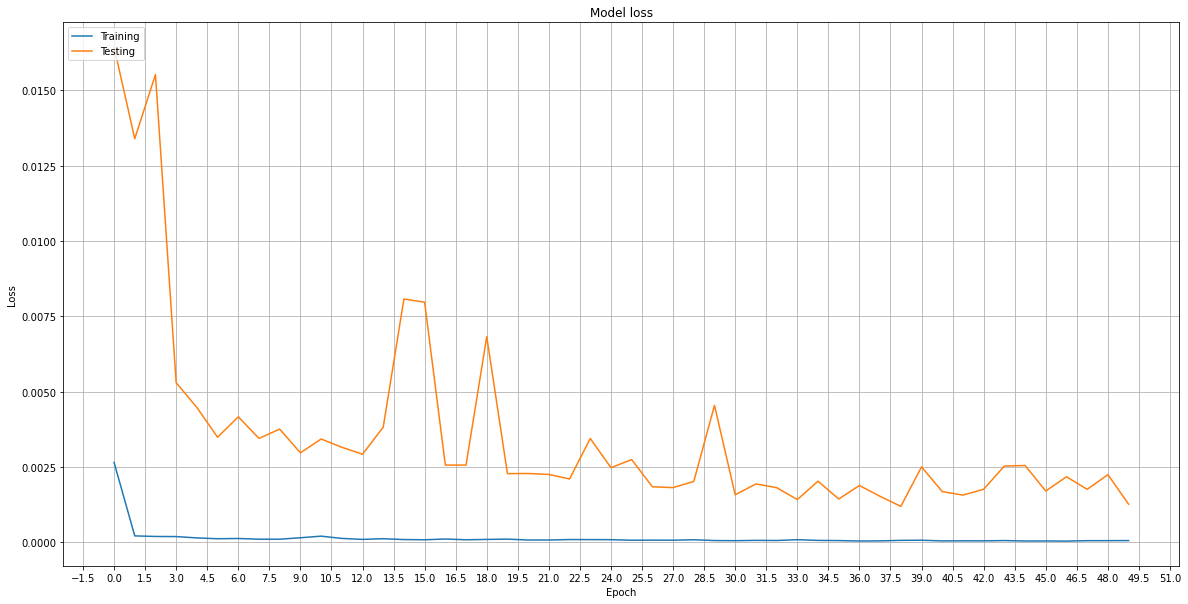

In [18]:
# Evaluate Model 1:
y_test_unscaled, y_pred = evaluate_model(model_1, x_test, y_test, scaler_pred)

# Plot training and testing loss values of model 1
history_accuracy_loss(history_1)

In [19]:
# Save the model 1
model_1.save('models/LSTM_model_1.h5') 

##### Model 2 Evaluation

R2 Score:  0.7809302042193995
Mean Absolute Error:  289.18251412982306
Mean Squared Error:  136397.69064900244
Mean Absolute Percentage Error: 8.57 %


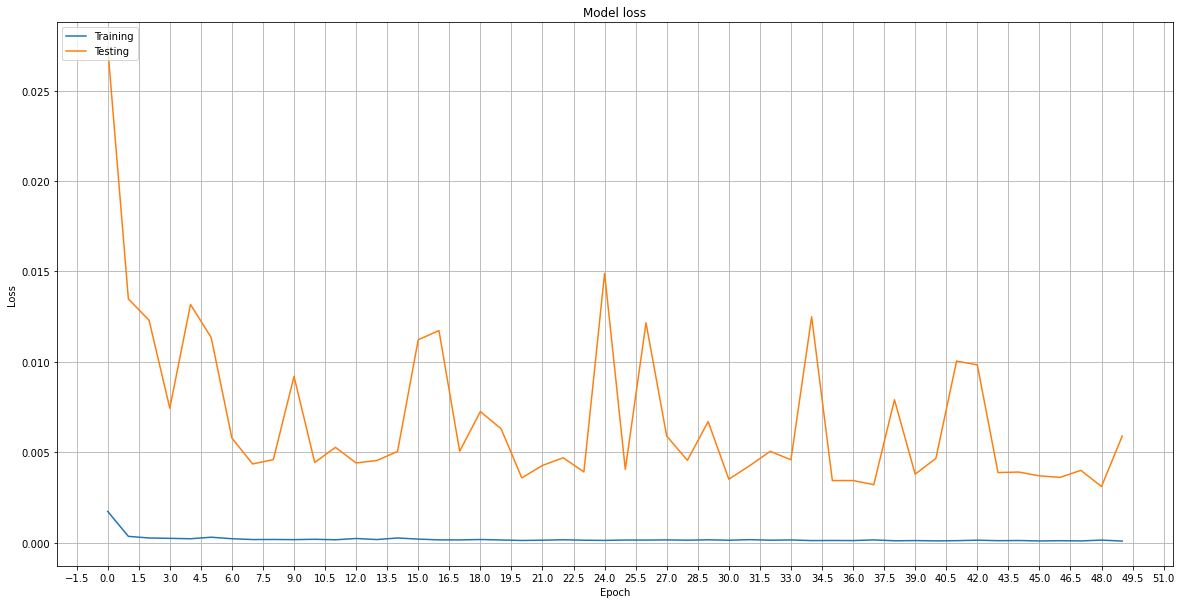

In [20]:
# Evaluate Model 2:
y_test_unscaled_2, y_pred_2 = evaluate_model(model_2, x_test, y_test, scaler_pred)

# Plot training and testing loss values of model 2
history_accuracy_loss(history_2)

In [21]:
# Save the model 2
model_2.save('models/LSTM_model_2.h5') 

### 7. Compare the Predicted and Actual Ethereum Prices

##### Model 1

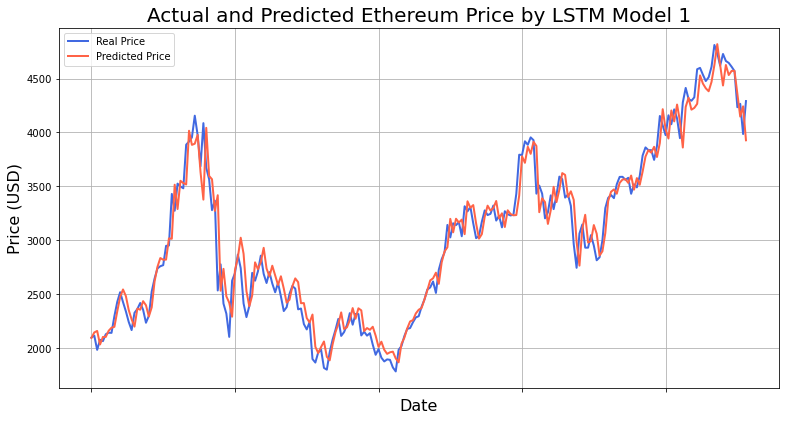

In [22]:
plot_actual_predicted(pd.DataFrame(y_test_unscaled), pd.DataFrame(y_pred), 'Actual and Predicted Ethereum Price by LSTM Model 1')

##### Model 2

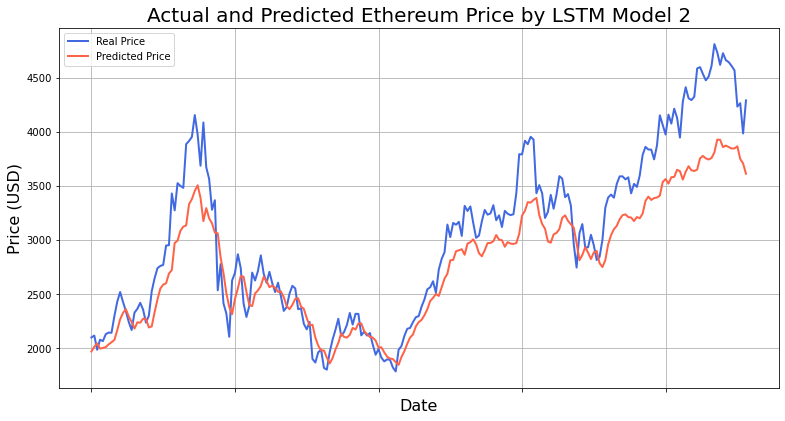

In [23]:
plot_actual_predicted(pd.DataFrame(y_test_unscaled_2), pd.DataFrame(y_pred_2), 'Actual and Predicted Ethereum Price by LSTM Model 2')

#### Conclusion:
As we can see in the evaluation session, Model 1 performs better than Model 2.

### 8. Predict the next day's price

We trained the model with data to 19-Nov, so we will predict the Ether price on 20-Nov based on the 7 previous days (from 13-Nov to 19-Nov). This is for testing purpose.

In [27]:
def predict_next_day_price(file_name, from_date, to_date, today):
   
    # Get today price on 20-Nov for checking
    df_lasted = pd.read_csv(file_name)
    price_today = round(df_lasted[df_lasted['date']==today]['PriceUSD'], 2)

    df_last_7_days = df[(df['date']<=to_date) & (df['date']>=from_date)]

    imp_features = ['PriceUSD', 'AdrActCnt', 'AdrBal1in100MCnt',
       'AdrBal1in10BCnt', 'AdrBal1in10MCnt', 'AdrBal1in1BCnt',
       'AdrBal1in1MCnt', 'CapMrktCurUSD', 'DiffLast',
       'DiffMean', 'FeeMedUSD', 'FeeTotUSD', 'FlowInExUSD',
       'FlowOutExUSD', 'GasUsedTx', 'GasUsedTxMean', 'HashRate',
       'RevHashNtv', 'RevHashRateUSD',
       'SplyAdrBalUSD1M', 'TxCnt', 'TxTfrValMedUSD']

    df_last_7_days = df_last_7_days[imp_features]
    last_7_days_scaled = scaler.transform(df_last_7_days)

    # Create an empty list and append past 7 days
    X_test_new = []
    X_test_new.append(last_7_days_scaled)

    # Predicted price for the next day
    pred_price_scaled = model_1.predict(np.array(X_test_new))
    pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
    predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)

    # Calculate the difference
    change_percent = round(abs(price_today - predicted_price),2)
    
    return price_today, predicted_price, change_percent

In [28]:
# Get today's price and compare with the predicted value 
price_today, predicted_price, change_percent = predict_next_day_price('data/eth_test.csv','2021-11-13', '2021-11-19', '2021-11-20')
print('The actual Ether price:', price_today.values)
print('The predicted Ether price:', predicted_price)
print('The difference is:', change_percent.values)

The actual Ether price: [4413.14]
The predicted Ether price: 4347.96
The difference is: [65.18]
